     地点编号  地点编号.1    公里数
0       1     100  21.14
1       1      16  30.67
2       2      85   9.91
3       2      90  28.11
4       3      24   6.20
..    ...     ...    ...
243   152     153   9.88
244   153     150  24.11
245   153     154  12.38
246   154      16  34.66
247   154     148  18.15

[248 rows x 3 columns]
[(1.0, 100.0, 21.14), (1.0, 16.0, 30.67), (2.0, 85.0, 9.91), (2.0, 90.0, 28.11), (3.0, 24.0, 6.2), (5.0, 60.0, 4.37), (5.0, 62.0, 27.87), (6.0, 63.0, 12.94), (6.0, 51.0, 9.73), (6.0, 66.0, 7.61), (7.0, 54.0, 23.47), (8.0, 68.0, 5.55), (8.0, 67.0, 11.45), (8.0, 71.0, 6.79), (9.0, 48.0, 16.58), (9.0, 55.0, 7.67), (10.0, 32.0, 9.3), (10.0, 31.0, 6.3), (11.0, 19.0, 15.41), (11.0, 22.0, 13.35), (13.0, 45.0, 35.52), (13.0, 119.0, 23.69), (14.0, 126.0, 13.6), (14.0, 109.0, 15.04), (15.0, 140.0, 18.62), (15.0, 105.0, 25.31), (15.0, 141.0, 6.41), (15.0, 142.0, 6.47), (16.0, 143.0, 18.06), (17.0, 108.0, 22.58), (18.0, 19.0, 29.33), (18.0, 31.0, 37.59), (19.0, 20.0, 26.51), (20.

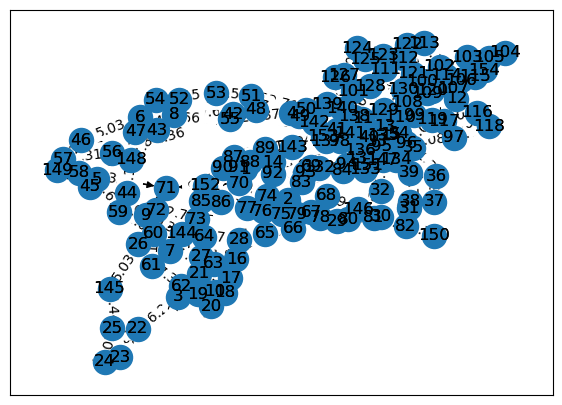

节点 22 到 32 的路径=['22', '25', '145', '26', '9', '28', '29', '30', '31', '32'], 最短距离=135.92000000000002
current function [networkx_dijkstra] run time is 0.0030
节点 24 到 32 的路径=['24', '25', '145', '26', '9', '28', '29', '30', '31', '32'], 最短距离=120.17
current function [networkx_dijkstra] run time is 0.0030
节点 27 到 32 的路径=['27', '28', '29', '30', '31', '32'], 最短距离=104.57000000000001
current function [networkx_dijkstra] run time is 0.1813
节点 31 到 32 的路径=['31', '32'], 最短距离=15.49
current function [networkx_dijkstra] run time is 0.0010
节点 34 到 32 的路径=['34', '35', '36', '37', '31', '32'], 最短距离=105.37
current function [networkx_dijkstra] run time is 0.0036
节点 36 到 32 的路径=['36', '37', '31', '32'], 最短距离=50.480000000000004
current function [networkx_dijkstra] run time is 0.0026
节点 42 到 32 的路径=['42', '41', '40', '35', '36', '37', '31', '32'], 最短距离=131.06
current function [networkx_dijkstra] run time is 0.0030


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
import pandas as pd
import pyscipopt as opt

def data_loader():
    origin_data = pd.read_excel('data/附件1：154个地点的平面直角坐标及距离数据.xlsx',sheet_name="地点间道路")
    print(origin_data)
    G = nx.Graph()
    G.add_nodes_from(origin_data["地点编号"],bipartite=0)
    G.add_nodes_from(origin_data["地点编号.1"],bitpartite=1)
    edge_list = origin_data.apply(lambda x:tuple(x),axis=1).values.tolist()
    print(edge_list)
    G.add_weighted_edges_from(edge_list)
    A=np.array(nx.adjacency_matrix(G).todense())
    df = pd.DataFrame(A)
    excel_filename = 'adjacency_matrix.xlsx'
    df.to_excel('./'+excel_filename)
    print(A)
    return A

def print_fun_run_time(func):
    def wrapper(*args, **kwargs):
        local_time = time.time()
        func(*args, **kwargs)
        print('current function [%s] run time is %.4f'%(func.__name__, time.time()-local_time))
    return wrapper


def pic_graph(Nodes, Arcs):
    """
    可视化图，节点的相对位置可能改变
    """
    np.random.seed(1)
    # 定义有向图
    Graph = nx.DiGraph()
    # 定义节点
    for node in Nodes:
        Graph.add_node(node, min_dis=0, previous_node=None, node_name=node)
    # 定义弧
    for (from_node, to_node), weight in Arcs.items():
        Graph.add_edge(from_node, to_node, weight=weight)

    plt.figure(figsize=(7, 5), dpi=100)
    pos = nx.spring_layout(Graph)

    nx.draw_networkx(Graph, pos)
    node_labels = nx.get_node_attributes(Graph, 'node_name')
    nx.draw_networkx_labels(Graph, pos, labels=node_labels)
    edge_labels = nx.get_edge_attributes(Graph, 'weight')
    nx.draw_networkx_edge_labels(Graph, pos, edge_labels=edge_labels)

    plt.savefig('./spp_grap.png')
    plt.show()

    return True


def prepare_data():
    # 测试数据: 邻接矩阵标识图结构，其中极大值1000表示不连通, 测试数据包含11个节点
    matrix = data_loader()

    # 转换数据（只是为了方便理解，不为效率）, 获取不包含本节点且连通的点及弧
    row, col = np.where((matrix != 1000) & (matrix != 0))
    Nodes = list(np.unique(np.unique(np.append(row, col)) + 1).astype('str'))
    Arcs = {}
    for i in range(len(row)):
        Arcs[str(row[i] + 1), str(col[i] + 1)] = matrix[row[i], col[i]]
    print('Nodes:\n', Nodes)
    print('Arcs:\n', Arcs)
    return Nodes, Arcs

@print_fun_run_time
def networkx_dijkstra(Nodes, Arcs, source, target):
    """
    networkx提供了dijkstra算法的方法的封装，只要定义图结构即可。感兴趣可以学一下networkx的源码。
    """
    Graph = nx.DiGraph()
    # 添加节点
    for node in Nodes:
        Graph.add_node(node, min_dis=0, previous_node=None, node_name=node)
    # 添加带权重的边
    for (from_node, to_node), weight in Arcs.items():
        Graph.add_weighted_edges_from([(from_node, to_node, weight)])

    path = nx.dijkstra_path(Graph, source=source, target=target)
    distance = nx.dijkstra_path_length(Graph, source=source, target=target)
    print(f'节点 {source} 到 {target} 的路径={path}, 最短距离={distance}')

    return True


@print_fun_run_time
def Dijkstra(Nodes, Arcs, source, target):
    """
    Parameters
    ----------
    Nodes: list
        the set of node

    Arcs: dict
        key: pairs of node (from node, end node)
        value: weight

    source : node
        Starting node

    target : node
        Ending node

    Returns
    -------
    path : list
        List of nodes in the shortest path
    distance: Float
        The short distance from source to target
    """
    # ========== 数据结构 ==========
    # 定义有向图
    Graph = nx.DiGraph()
    # 定义节点
    for node in Nodes:
        Graph.add_node(node, min_dis=0, previous_node=None, node_name=node)
    # 定义弧
    for (from_node, to_node), weight in Arcs.items():
        Graph.add_edge(from_node, to_node, weight=weight)

    # ========== 算法开始 ==========
    # 初始化未探索节点集合: 初始时为所有节点集合
    tmp_set = list(Graph.nodes())

    # 初始化当前节点及所有节点的最短距离：起始点作为当前节点，并将起始点的最短路径置为0，其他节点距离置为无穷大
    current_node = source
    for node in tmp_set:
        if (node == source):
            Graph.nodes[node]['min_dis'] = 0
        else:
            Graph.nodes[node]['min_dis'] = np.inf

    # 算法终止条件: 所有节点均被探索
    while (len(tmp_set) > 0):
        # 选择未探索的节点中的最短路径的节点作为新的当前节点
        min_dis = np.inf
        for node in tmp_set:
            if (Graph.nodes[node]['min_dis'] < min_dis):
                current_node = node
                min_dis = Graph.nodes[node]['min_dis']

        # 删除已探索的节点
        if (current_node != None):
            tmp_set.remove(current_node)

        """
        循环判断当前节点所有相邻的节点：
        1. 计算当前节点的最小值 + 相邻节点的权重的和，
        2. 若小于相邻节点的最小距离，则更新相邻节点的最小距离，并标记相邻节点的前一个节点为当前节点
        """
        for neighbor_node in Graph.successors(current_node):
            arc = (current_node, neighbor_node)
            dis_t = Graph.nodes[current_node]['min_dis'] + Graph.edges[arc]['weight']
            if (dis_t < Graph.nodes[neighbor_node]['min_dis']):
                Graph.nodes[neighbor_node]['min_dis'] = dis_t
                Graph.nodes[neighbor_node]['previous_node'] = current_node

    # ========== 获取结果 ==========
    """
    获取结果:
    1. 结束节点上更新的最短距离即为整个最短路径的距离
    2. 根据结束节点回溯, 依次找到其上一个节点
    """
    distance = Graph.nodes[target]['min_dis']
    current_node = target
    path = [current_node]
    while (current_node != source):
        current_node = Graph.nodes[current_node]['previous_node']
        path.insert(0, current_node)

    print(f'节点 {source} 到 {target} 的路径={path}, 最短距离={distance}')
    return True


if __name__ == '__main__':
    source = ['32']  # starting node
    target = ['22','24','27','31','34','36','42']  # ending node
    # 测试数据
    Nodes, Arcs = prepare_data()
    # 可视化图
    pic_graph(Nodes, Arcs)
    #求每个军事据点到每个生产基地的距离
    for i in target:
        for j in source:
            networkx_dijkstra(Nodes, Arcs, i, j)
            # Dijkstra(Nodes, Arcs, i, j)
    # 方式1: 使用networkx提供了dijkstra算法的方法的封装
    # networkx_dijkstra(Nodes, Arcs, source, target)
    # 方式2: python实现Dijkstra算法求解最短路径问题
    # Dijkstra(Nodes, Arcs, source, target)
